# Kaufmann vortex flow
In this notebook we benchmark the implementation of the Maxey-Riley (MR)   
equations in parcels using the Kaufmann vortex flow (2D stationary vortex)  

The trajectory of inertial particles in the kaufmann vortex flow is set by  
its buoyancy:
- negatively buoyant particles will be repelled out of the vortex
- neutrally buoyant particles will follow the streamlines, keeping a  
fixed distance from the particles. 
- positively buoyant particles will be attracted to the center of the vortex


In [77]:
# import needed packages
import sys
sys.path.append('../')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta 
from parcels import FieldSet, ParticleSet, ParticleFile
from parcels import AdvectionRK4
from functions.kernels import InertialParticle2D, InitializeParticles2D, MRAdvectionRK4_2D, MRSMAdvectionRK4_2D


plt.style.use('../python_style_Meike.mplstyle')

In [78]:
# print python version
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, parcels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.12.2 64bit [GCC 12.3.0]
IPython 8.22.2
OS Linux 4.18.0 553.22.1.el8_10.x86_64 x86_64 with glibc2.28
numpy 1.26.4
matplotlib 3.8.3
xarray 2024.2.0
parcels 3.0.2
Thu Oct 31 11:34:38 2024 CET

## Defining flowfield
The kaufmann vortex flow is given by (in polar coordinates)    
$$u(r,\theta)=\gamma/2\pi * r/(a^2+r^2) \hat{\theta}$$
We use $a = 50$, $\gamma = 2\pi$. As parcels works with a flowfield on a grid we discretize the field on a grid   
from $-50$ m to $50$ m in $x$ and $y$ and gridspacing $dx = dy = 0.5$ (thus 1000 gridpoints in each dimensions)

In [79]:
def kaufmann_vortex_field(gamma, a, xmin,xmax,ymin,ymax,dx,dy):
    """ function that creates kaufmann vortex field on a grid.     
    """
    x=np.arange(xmin,xmax+0.5*dx,dx)
    y=np.arange(ymin,ymax+0.5*dy,dy)
    X,Y=np.meshgrid(x,y)
    rr=X**2+Y**2
    r=np.sqrt(rr)
    aa=a*a
    speed=gamma / (2*np.pi) * rr/(aa+rr) # gamma/(2*np.pi)
 
    theta=np.arctan2(Y,X)
    U=speed*(-np.sin(theta))
    V=speed*(np.cos(theta))
    return X, Y, U, V

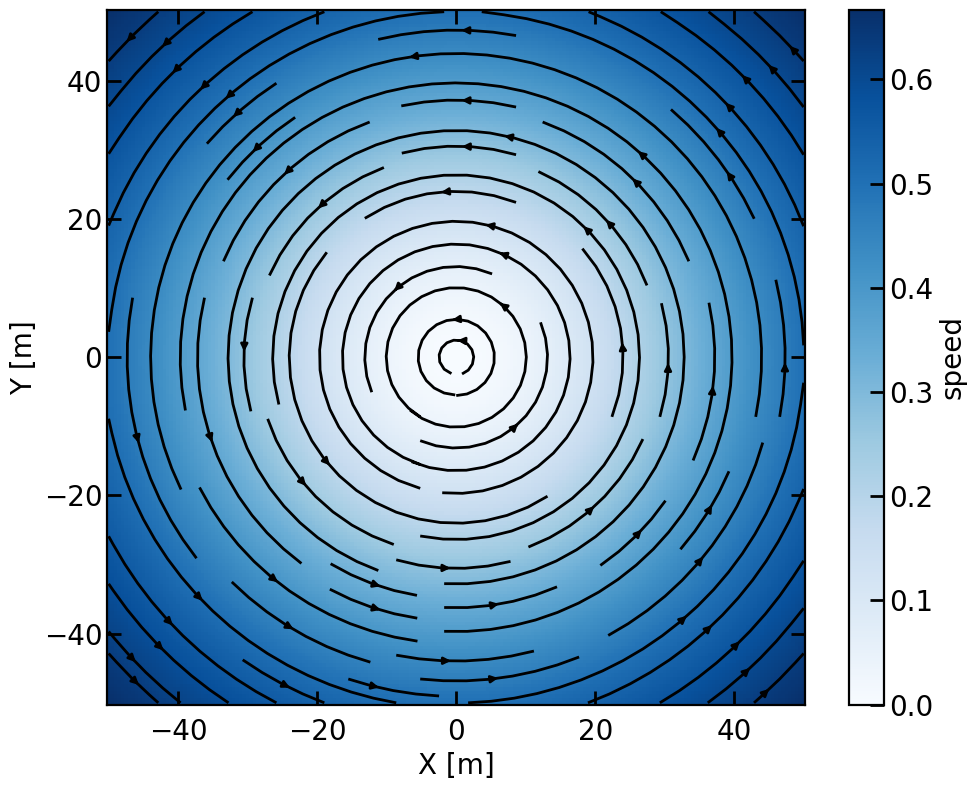

In [ ]:
#create field
X, Y, U, V = kaufmann_vortex_field(gamma=2*np.pi,a=50,xmin=-50,xmax=50,ymin=-50,ymax=50,dx=0.5,dy=0.5)

#save field in dictionary
data_kaufmann_vortex_field = {
    "U": U,
    "V": V
    }

dims_kaufmann_vortex_field = {
    "lon": X,
    "lat": Y
    }

#plot field
fig, ax = plt.subplots()
ax.streamplot(X, Y, U, V,color='k')
pcm = ax.pcolormesh(X, Y, np.sqrt(U * U + V * V),cmap='Blues')
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
cbar = fig.colorbar(pcm,label='speed')
fig.tight_layout()

## Parcels simulation
We perform 6 parcels simulations; 3 with the complete maxey riley equations (MR)   
and 3 with the slow manifold maxey riley eqatuions (MRSM).   
For each set we use 3 different values of the buoyancy: 
- B = 0.8 (positivley buoyant)
- B = 1.0 (neutrally buoyant)
- B = 1.2 (negatively buoyant) 

For all simulations we use a stokes relaxation time of $ \tau  = 10$ s. 

In [ ]:
# set fieldset
fieldset = FieldSet.from_data(
    data = data_kaufmann_vortex_field,
    dimensions = dims_kaufmann_vortex_field,
    mesh="flat",
    allow_time_extrapolation=True
)
# add rotation here 0 as we have flat mesh
fieldset.add_constant('Omega_earth', 0) 

# stepsize for finite differences calculation
Delta_x = fieldset.U.grid.lon[0,1]-fieldset.U.grid.lon[0,0]
Delta_y = fieldset.U.grid.lat[1,0]-fieldset.U.grid.lat[0,0]
delta_x = 0.5 * Delta_x
delta_y = 0.5 * Delta_y
fieldset.add_constant('delta_x', delta_x)
fieldset.add_constant('delta_y', delta_y)
print(f'(delta x, delta y) = ({delta_x}, {delta_y})')


(delta x, delta y) = (0.25, 0.25)


In [91]:
# simulation of particles using the full Maxey-Riley equation
Buoyancies = np.array([0.8, 1.0, 1.2])
tau = 10. # * 10**(-1)
nparticles = 5
xstart = np.linspace(0,10,nparticles)
ystart = np.zeros(nparticles)
taulist = np.full(nparticles,tau)
times = np.zeros(nparticles)

dt_timestep = timedelta(seconds=1)
runtime = timedelta(hours=1)
dt_write = timedelta(seconds=10)

for B in Buoyancies:

    print(f'start MR simulation with buoyancy = {B}')
    Blist=np.full(nparticles,B)
    output_file = f'MR_kaufmann_{int(1000*B):04d}.zarr' 


    pset = ParticleSet.from_list(fieldset, InertialParticle2D, lon=xstart,
                                    lat=ystart, time =times,B=Blist, tau=taulist)
    pfile = ParticleFile(output_file, pset, outputdt=dt_write)

    # initialize velocity particles with velocity field
    pset.execute([InitializeParticles2D], runtime=1, dt=1, verbose_progress=True)
    # run simulation

    kernel =[MRAdvectionRK4_2D]
    pset.execute(kernel, runtime=runtime, dt=dt_timestep, output_file=pfile)
    


start MR simulation with buoyancy = 0.8

100%|██████████| 1.0/1.0 [00:00<00:00, 783.84it/s]
 29%|██▊       | 3080.0/10800.0 [07:08<17:53,  7.19it/s]
INFO: Output files are stored in MR_kaufmann_0800.zarr.
100%|██████████| 3600.0/3600.0 [09:33<00:00,  6.28it/s]
start MR simulation with buoyancy = 1.0
100%|██████████| 1.0/1.0 [00:00<00:00, 864.09it/s]
INFO: Output files are stored in MR_kaufmann_1000.zarr.
100%|██████████| 3600.0/3600.0 [13:19<00:00,  4.50it/s]
start MR simulation with buoyancy = 1.2
100%|██████████| 1.0/1.0 [00:00<00:00, 839.36it/s]
INFO: Output files are stored in MR_kaufmann_1200.zarr.
100%|██████████| 3600.0/3600.0 [09:35<00:00,  6.26it/s]


In [92]:
# simulation of particles using the slow manifold (reduced) Maxey-Riley equation
Buoyancies = np.array([0.8, 1.0, 1.2])
tau = 10. # * 10**(-1)
nparticles = 5
xstart = np.linspace(0,10,nparticles)
ystart = np.zeros(nparticles)
taulist = np.full(nparticles,tau)
times = np.zeros(nparticles)

dt_timestep = timedelta(seconds=10)
runtime = timedelta(hours=1)
dt_write = timedelta(seconds=10)

for B in Buoyancies:

    print(f'start MR simulation with buoyancy = {B}')
    Blist=np.full(nparticles,B)
    output_file = f'MRSM_kaufmann_{int(1000*B):04d}.zarr' 


    pset = ParticleSet.from_list(fieldset, InertialParticle2D, lon=xstart,
                                    lat=ystart, time =times,B=Blist, tau=taulist)
    pfile = ParticleFile(output_file, pset, outputdt=dt_write)

    # initialize velocity particles with velocity field
    pset.execute([InitializeParticles2D], runtime=1, dt=1, verbose_progress=True)
    # run simulation

    kernel =[MRSMAdvectionRK4_2D]
    pset.execute(kernel, runtime=runtime, dt=dt_timestep, output_file=pfile)
    


start MR simulation with buoyancy = 0.8
100%|██████████| 1.0/1.0 [00:00<00:00, 833.86it/s]
INFO: Output files are stored in MRSM_kaufmann_0800.zarr.
100%|██████████| 3600.0/3600.0 [00:47<00:00, 75.82it/s] 
start MR simulation with buoyancy = 1.0
100%|██████████| 1.0/1.0 [00:00<00:00, 867.31it/s]
INFO: Output files are stored in MRSM_kaufmann_1000.zarr.
100%|██████████| 3600.0/3600.0 [00:43<00:00, 83.42it/s] 
start MR simulation with buoyancy = 1.2
100%|██████████| 1.0/1.0 [00:00<00:00, 875.64it/s]
INFO: Output files are stored in MRSM_kaufmann_1200.zarr.
100%|██████████| 3600.0/3600.0 [00:41<00:00, 86.15it/s] 


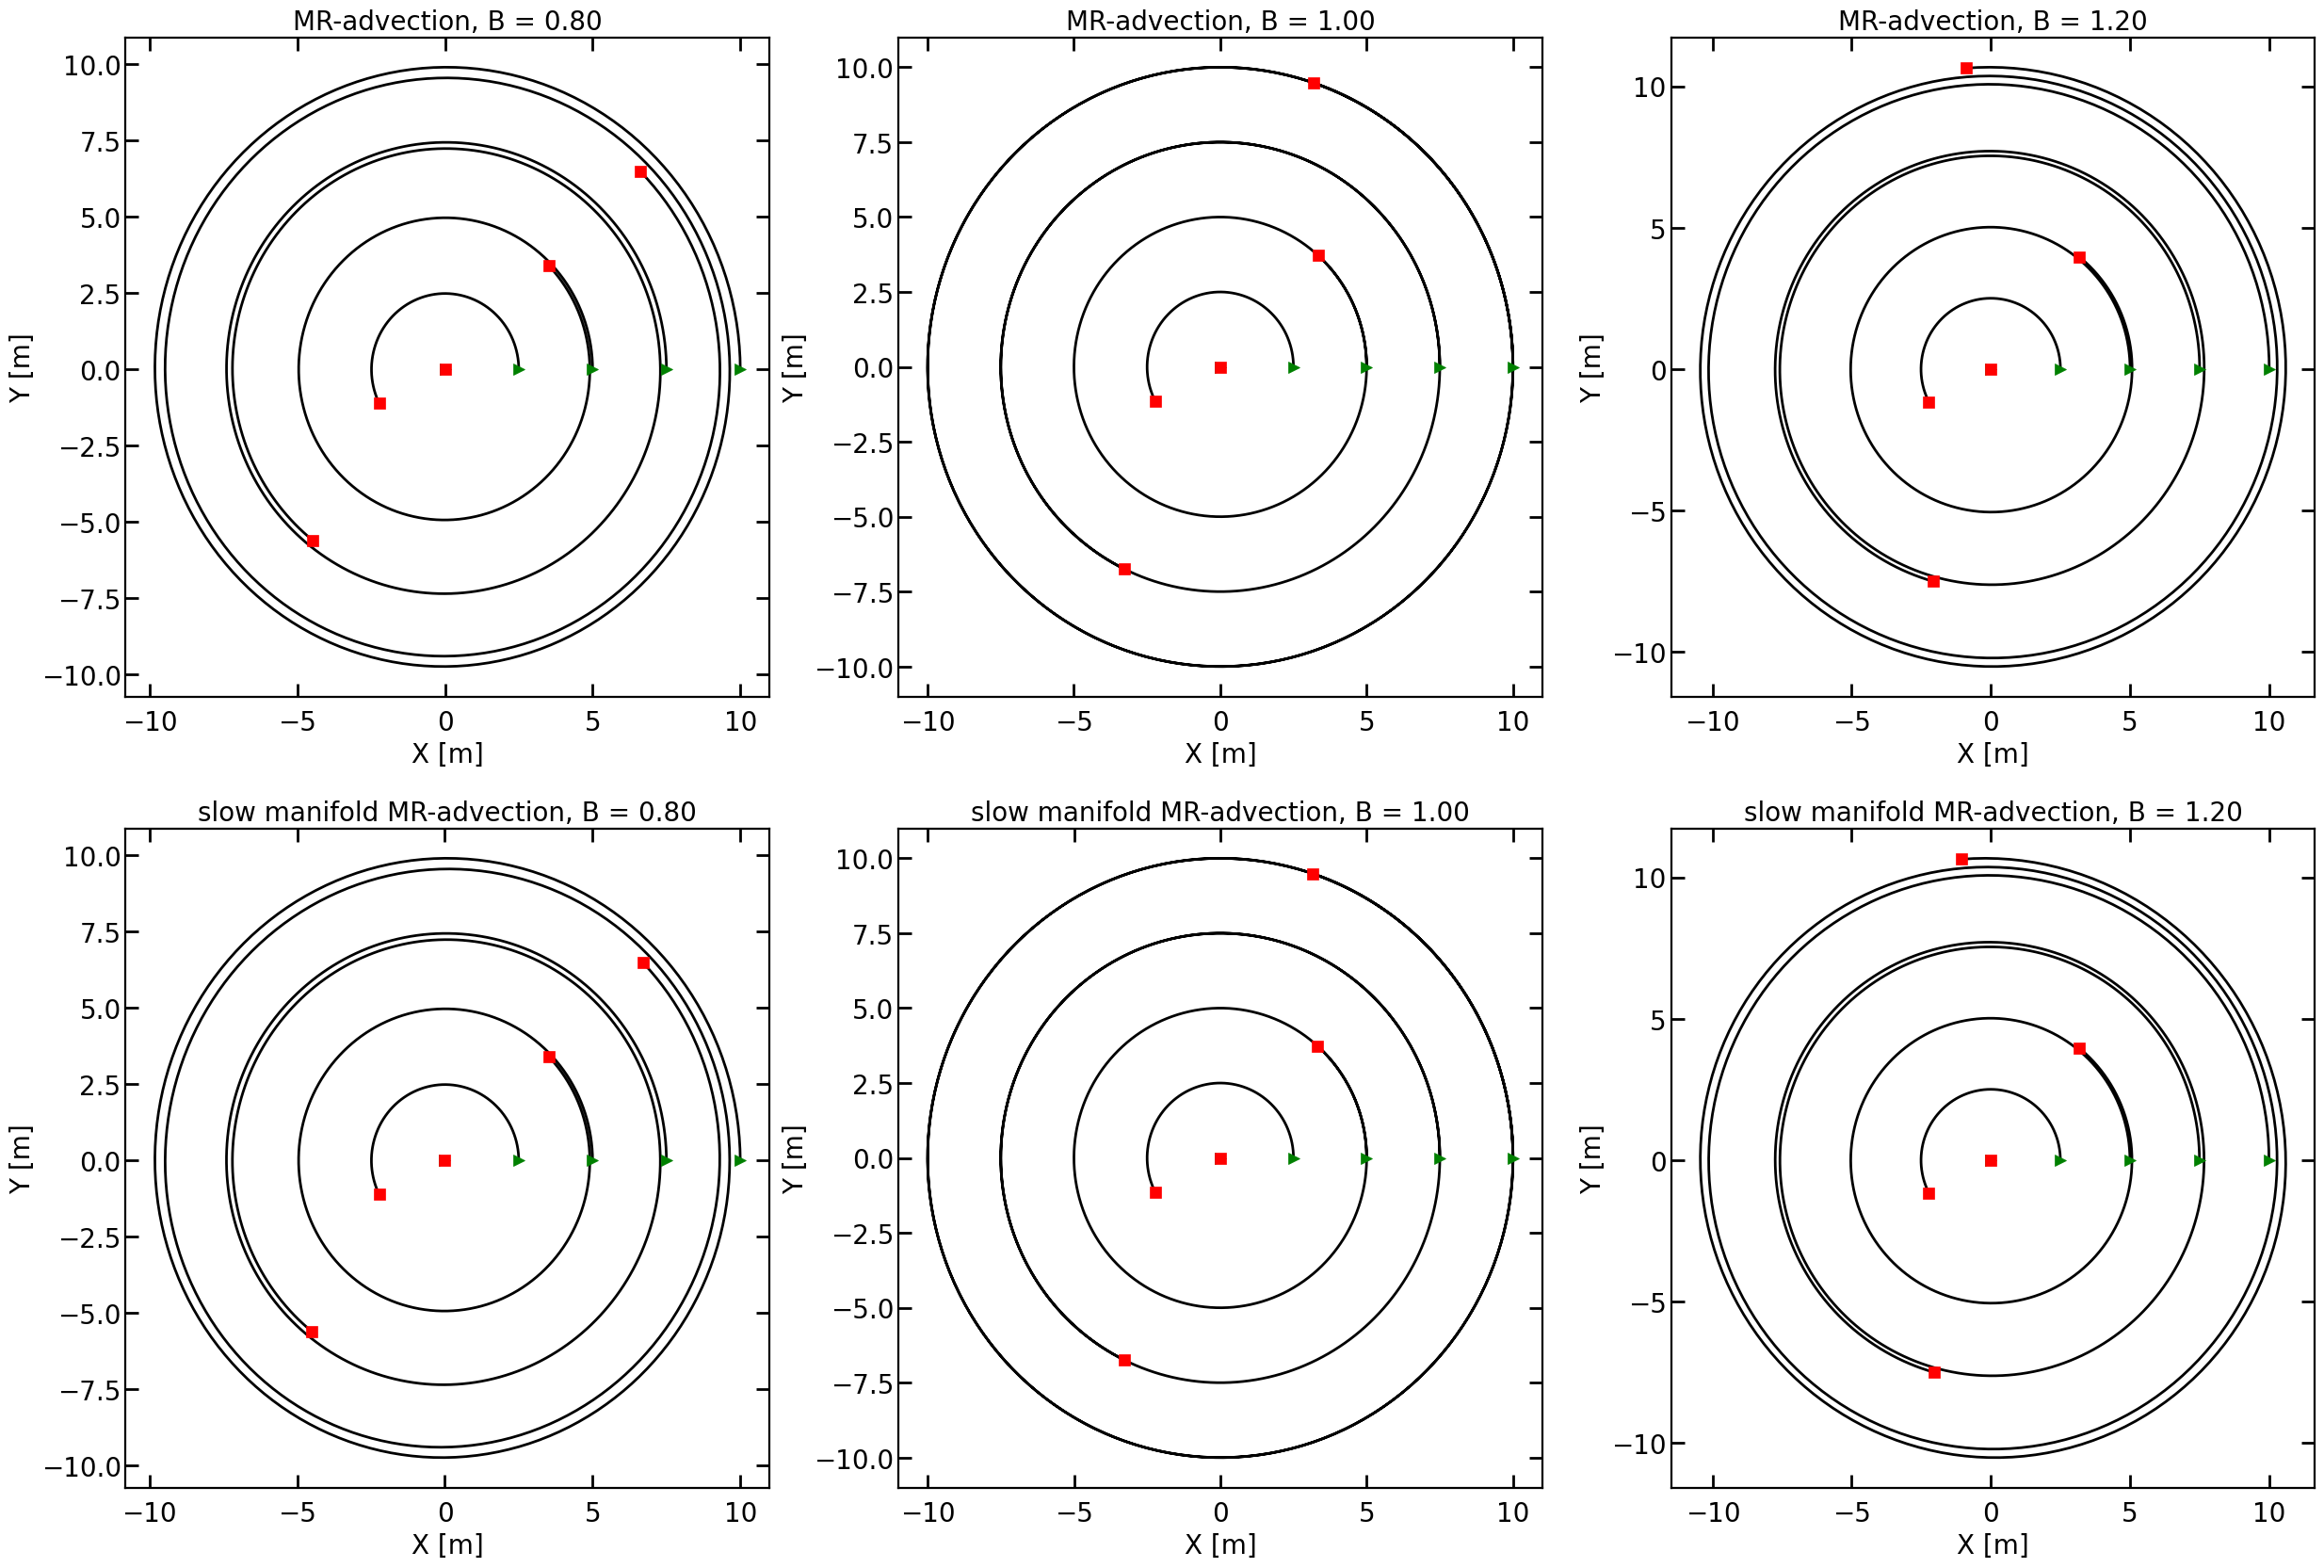

In [93]:
fig,axs = plt.subplots(2, 3, figsize=(30,20))

j=0
for B in Buoyancies:
    input_file_MR = f'MR_kaufmann_{int(1000*B):04d}.zarr' 
    ds_MR = xr.open_zarr(input_file_MR)
    input_file_MRSM = f'MRSM_kaufmann_{int(1000*B):04d}.zarr' 
    ds_MRSM = xr.open_zarr(input_file_MRSM)
    axs[0,j].plot(ds_MR.lon.T,ds_MR.lat.T, '-', color='k', zorder=-20)
    axs[0,j].plot(ds_MR.lon[:,0].T, ds_MR.lat[:,0].T,'>', color='green')
    axs[0,j].plot(ds_MR.lon[:,-1].T, ds_MR.lat[:,-1].T,'s', color='red')

    axs[1,j].plot(ds_MRSM.lon.T,ds_MR.lat.T, '-', color='k', zorder=-20)
    axs[1,j].plot(ds_MRSM.lon[:,0].T, ds_MR.lat[:,0].T,'>', color='green')
    axs[1,j].plot(ds_MRSM.lon[:,-1].T, ds_MR.lat[:,-1].T,'s', color='red')

    axs[0,j].set_xlabel('X [m]')
    axs[0,j].set_ylabel('Y [m]')

    axs[1,j].set_xlabel('X [m]')
    axs[1,j].set_ylabel('Y [m]')

    axs[0,j].set_title(f'MR-advection, B = {B:.2f}',fontsize=20)
    axs[1,j].set_title(f'slow manifold MR-advection, B = {B:.2f}',fontsize=20)
    j+=1



